In [2]:
'''
::by:: 
::version::python 3.8.8
'''
import pandas as pd
import numpy as np

import warnings    #忽略警告
warnings.filterwarnings("ignore", category=Warning)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']        # 字体设置
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False    # 负号显示问题

from arch.unitroot import ADF                     
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import coint
import statsmodels.formula.api as smf

import tushare as ts
import math
from ypstruct import structure

%config InlineBackend.figure_format = 'svg' # 'retina'

### 4.1协整检验

#### 4.1.1单位根检验

In [3]:
sh = pd.read_csv('arch.csv',index_col='date')
sh.index = pd.to_datetime(sh.index)
sh.rename(columns={'hkex.smics': 'hkex_smics','sse.smics': 'sse_smics'}, inplace=True)

In [17]:
#原始数据
hkex_c=sh['hkex_smics']
sse_c=sh['sse_smics']

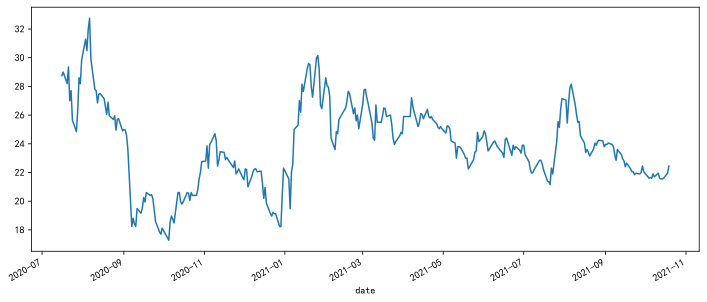

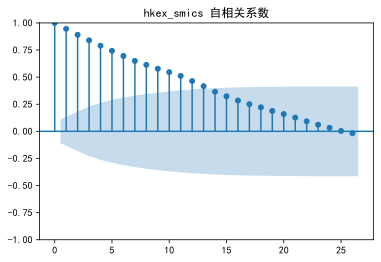

In [39]:
hkex_c.plot(figsize=(12,5))
plot_acf(hkex_c,title='hkex_smics 自相关系数').savefig('hkex_smics 自相关系数.svg')
plt.show()

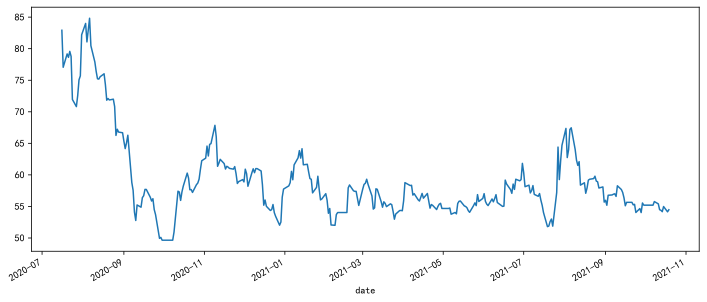

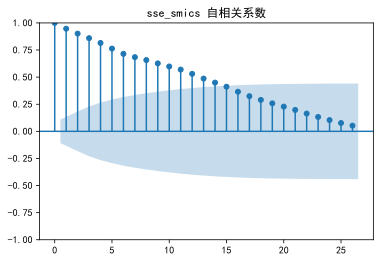

In [41]:
sse_c.plot(figsize=(12,5))
plot_acf(sse_c,title='sse_smics 自相关系数').savefig('sse_smics 自相关系数.svg')
plt.show()

In [20]:
#定义显示adf结果的函数
def adf_results(col_adf):
    output = pd.Series(col_adf[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in col_adf[4].items():
        output['Critical Value (%s)' % key] = value
    print(output)

In [22]:
#做一阶差分后的数据
sse_c1=sse_c.diff(1).dropna()
hkex_c1=hkex_c.diff(1).dropna()

##### 原始变量差分后做单位根检验（通过）

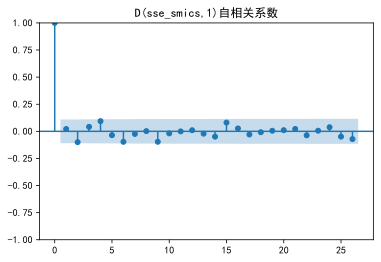

In [42]:
plot_acf(sse_c1,title='D(sse_smics,1)自相关系数').savefig('D(sse_smics,1)自相关系数.svg')
plt.show()

In [24]:
adf_results(sm.tsa.stattools.adfuller(sse_c1))

Test Statistic                -8.145477e+00
p-value                        1.001611e-12
#Lags Used                     3.000000e+00
Number of Observations Used    3.160000e+02
Critical Value (1%)           -3.451215e+00
Critical Value (5%)           -2.870730e+00
Critical Value (10%)          -2.571666e+00
dtype: float64


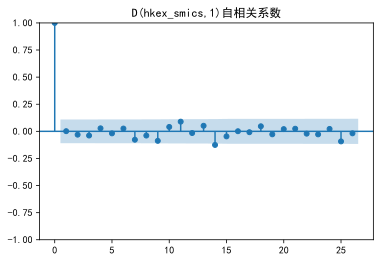

In [43]:
plot_acf(hkex_c1,title='D(hkex_smics,1)自相关系数').savefig('D(hkex_smics,1)自相关系数.svg')
plt.show()

In [26]:
adf_results(sm.tsa.stattools.adfuller(hkex_c1))

Test Statistic                -1.777136e+01
p-value                        3.306439e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.190000e+02
Critical Value (1%)           -3.451017e+00
Critical Value (5%)           -2.870643e+00
Critical Value (10%)          -2.571620e+00
dtype: float64


##### 同时做完一阶差分后均满足一阶单整，可以进行协整检验，下面使用EG两步法进行协整检验

#### 4.1.2EG两步法

In [855]:
results=smf.ols('sse_smics ~ hkex_smics', data=sh).fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnsse_c   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     148.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.39e-28
Time:                        17:21:08   Log-Likelihood:                 335.73
No. Observations:                 321   AIC:                            -667.5
Df Residuals:                     319   BIC:                            -659.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5288      0.127     19.937      0.000       2.279       2.778
lnhkex_c       0.4881      0.040     12.198      0.000       0.409       0.567
==============================================================================
Omnibus:                       23.392   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.933
Skew:                           0.709   Prob(JB):                     1.42e-06
Kurtosis:                       3.060   Cond. No.                         92.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [856]:
sh['residual'] = sse_c - hkex_c* results.params[1]  - results.params[0] 
adf_results(sm.tsa.stattools.adfuller(sh['residual'],regression='n')) #n::无恒定，无趋势，默认为c::常数

Test Statistic                  -2.966765
p-value                          0.002963
#Lags Used                       4.000000
Number of Observations Used    316.000000
Critical Value (1%)             -2.572852
Critical Value (5%)             -1.941883
Critical Value (10%)            -1.616006
dtype: float64


### 4.2误差修正模型

In [857]:
dat['residual']=sh['residual'][1:]
ECM = smf.ols(formula='sse_c1 ~ hkex_c1 + residual',data = dat).fit()
print(ECM.summary())
print(ECM.params)

                            OLS Regression Results                            
Dep. Variable:                 sse_c1   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     132.2
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.78e-42
Time:                        17:22:20   Log-Likelihood:                -524.85
No. Observations:                 320   AIC:                             1056.
Df Residuals:                     317   BIC:                             1067.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0630      0.070     -0.898      0.3

### 4.3套利模型的构建

#### 4.3.1开平仓示例

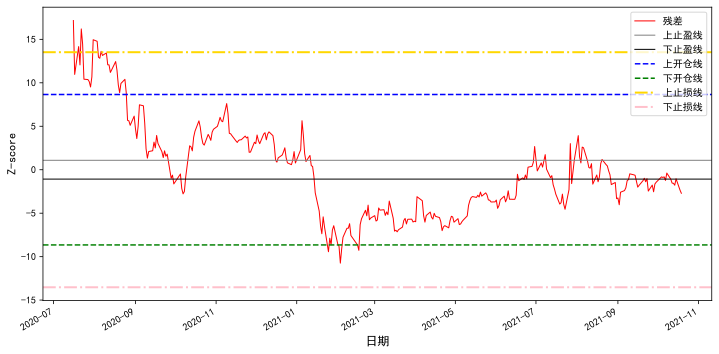

In [44]:
## 此处需要先执行一下后面的Cointe类
trade_start,trade_end=0,322
trade_data,trade_sse,trade_hkex,trade_results,CoSpreadTrade=Cointe.split_data(sh,trade_start,trade_end)

x1,x2,x3,x4,x5,x6=0.2,0.2,1.6,1.6,2.5,2.5
mu=CoSpreadTrade.mean()
sd=CoSpreadTrade.std()

plt.figure(figsize=(12,6))
CoSpreadTrade.plot(label='残差',color='red',lw=1)
plt.axhline(y=mu+x1*sd,color='gray',ls='-',lw=1,label='上止盈线')
plt.axhline(y=mu-x2*sd,color='black',ls='-',lw=1,label='下止盈线')
plt.axhline(y=mu+x3*sd,color='blue',ls='--',lw=1.5,label='上开仓线')
plt.axhline(y=mu-x4*sd,color='green',ls='--',lw=1.5,label='下开仓线')
plt.axhline(y=mu+x5*sd,color='gold',ls='-.',lw=2,label='上止损线') 
plt.axhline(y=mu-x6*sd,color='pink',ls='-.',lw=2,label='下止损线') 
plt.ylabel('Z-score',fontsize='12')
plt.xlabel('日期',fontsize='12')
plt.legend()
plt.savefig('开平仓示例.svg')
plt.show()

#### 4.3.2 基于遗传算法的协整统计套利策略

In [45]:
class Trade():
    '''
    交易类，每一个配对期残差通过协整检验后将被调用。
    
    '''
    def __init__(self,match_results,CoSpreadMatch,sh,trade_start,trade_end,x1,x2,x3,x4,x5,x6): #
        self.results=match_results
        self.CoSpreadMatch=CoSpreadMatch
        self.sh=sh
        self.trade_start=trade_start
        self.trade_end=trade_end
        self.x1=x1
        self.x2=x2
        self.x3=x3
        self.x4=x4
        self.x5=x5
        self.x6=x6

        trade_data,trade_sse,trade_hkex,trade_results,CoSpreadTrade=Cointe.split_data(sh,trade_start,trade_end) 
        self.trade_data=trade_data
        self.trade_sse=trade_sse
        self.trade_hkex=trade_hkex
        self.trade_results=trade_results
        self.CoSpreadTrade=CoSpreadTrade
    
    #划分触发区间
    def PrcLevel(self,):

        # 绘制价格区间图（交易期）
        mu=self.CoSpreadMatch.mean()
        sd=self.CoSpreadMatch.std()

        # 设置触发区间
        level = (float('-inf'),mu-x6*sd,mu-x4*sd,mu-x2*sd,mu+x1*sd,mu+x3*sd,mu+x5*sd,float('inf'))

        # 触发区间分箱
        prcLevel = pd.cut(self.CoSpreadTrade,level,labels=False)-3  
        return prcLevel

    # 构造交易信号函数
    def TradeSig(self):
        prcLevel=self.PrcLevel()
        n = len(prcLevel)
        signal = np.zeros(n)

        flag=0
        for i in range(1,n):
            if flag!=1 and prcLevel[i-1] <2  and prcLevel[i] == 2:   # 价差上穿2区，反向建仓        
                flag=signal[i] = -2
            elif flag==-2 and prcLevel[i-1] == 1 and prcLevel[i]<1:       # 价差从1区下穿，则平仓之前上穿2区
                signal[i] = 2
                flag=0
            elif flag==-2 and prcLevel[i-1] == 2 and prcLevel[i] !=2 and prcLevel[i] !=1:     # 价差从2区到非2区非1区，平仓上穿2区
                signal[i] = 3
                flag=0
            elif flag !=-2 and prcLevel[i-1] >-2 and prcLevel[i] == -2 :   # 价差下穿-2区，正向建仓    
                flag=signal[i] = 1
            elif flag==1 and prcLevel[i-1] == -1 and prcLevel[i] > 0:      # 价差从-1区上穿，平仓之前下穿
                signal[i] = -1
                flag=0
            elif flag==1 and prcLevel[i-1] == -2 and prcLevel[i]!=-2 and prcLevel[i]!=-1 : # 价差从-2区到非-2非-1区，平仓之前下穿-2区
                signal[i] = -3
                flag=0
        return signal

    # 设置每个每天的交易信号
    def Pos(self,):
        signal = self.TradeSig()
        position = [signal[0]]
        ns = len(signal)

        # 设置每天开仓、平仓指令
        for i in range(1,ns):
            position.append(position[-1])
            if signal[i] == 1 :
                position[i] = 1                 
            elif signal[i] == -2 :
                position[i] = -1               
            elif signal[i] !=0:
                position[i] = 0                

        position=pd.Series(position,index=self.trade_hkex.index)
        return position
    

    # 构造交易模拟函数  为提高资金利用效率，下面进行的是融资融券交易，即A股也可以做空
    def TradeSim(self,last_account,cash=[1000000]):
        priceX=self.trade_hkex
        priceY=self.trade_sse
        position=self.Pos()
        n = len(position)

        # 设置alpha、beta（交易头寸，即投资比例）
        alpha = self.results.params[0]
        beta = self.results.params[1]
        
        # 设置融资融券股数，假设保证金为50%，即两倍杠杆
        size =cash[0]/priceY[0]//100*100               

        # 设置中芯国际A股投入金额和期初一样，H股投入金额与A股一致
        shareY = size * position
        shareX =[((-beta)* priceX[0]) * shareY[0]  / priceX[0]//100*100]   

        sx*px=sy(bx+a)

        # 获取融资融券持仓股票数以及资产变动情况
        for i in range(1,n):
            shareX.append(shareX[i-1])
            cash.append(cash[i-1])
            if position[i-1] == 0 and position[i] == 1:
                shareX[i] = (-beta*priceX[i]) * shareY[i]  / priceX[i]//100*100
                cash[i] = cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
            elif position[i-1] == 0 and position[i] == -1:
                shareX[i] = (-beta*priceX[i]) * shareY[i]  / priceX[i]//100*100
                cash[i] = cash[i-1]-(shareY[i]*priceY[i]+shareX[i]*priceX[i])
            elif position[i-1] == 1 and position[i] == 0:
                shareX[i] = 0
                cash[i] = cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
            elif position[i-1] == -1 and position[i] == 0:
                shareX[i] = 0
                cash[i] = cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])
            elif i==n-1 and position[i]!=0:  # 交易期结束如果有仓位将强制平仓
                shareX[i] = 0
                shareY[i] = 0
                cash[i] = cash[i-1]+(shareY[i-1]*priceY[i]+shareX[i-1]*priceX[i])

        # 将数据封装进dataframe
        cash = pd.Series(cash,index=position.index)
        shareY = pd.Series(shareY,index=position.index)
        shareX = pd.Series(shareX,index=position.index)
        asset = cash + shareY*priceY + shareX*priceX
        account = pd.DataFrame({'Position':position,'ShareY':shareY,'ShareX':shareX,'Cash':cash,'Asset':asset})

        # 非第一个交易期则进行拼接
        if not last_account.empty:
            account=pd.concat([last_account,account])
        return account
    


In [54]:
class Cointe():
    '''
    协整检验配对和交易类
    '''
    def _init(self,sh):
        self.sh=sh

    # 对原始数据进行划分，得到相关数据
    def split_data(sh,start,end):
        data_=sh.iloc[start:end,:]
        sse_ =data_.loc[:,'sse_smics']
        hkex_=data_.loc[:,'hkex_smics']
        results_=smf.ols('sse_smics ~ hkex_smics', data=data_).fit()
        data_['residual'] = sse_ - hkex_* results_.params[1] - results_.params[0] 
        return data_,sse_ ,hkex_,results_,data_['residual']

    def main_(sh,match_days,trade_days,x1,x2,x3,x4,x5,x6):
        '''
        ::sh::带需配对股票的价格的DataFrame
        下面是需要寻优的八个参数,所有参数均为大于等于0
        ::match_days::配对期（天）
        ::trade_days::交易期（天）
        ::x1::上止盈线阈值
        ::x2::下止盈线阈值
        ::x3::上开仓线阈值
        ::x4::下开仓线阈值
        ::x5::上止损线阈值
        ::x6::下止损线阈值
        '''
        match_start=0
        account=pd.DataFrame()
        while match_start+match_days+trade_days <sh.shape[0]:
            match_end=match_start+match_days
            trade_start=match_end
            trade_end=trade_start+trade_days
            match_data,match_sse,match_hkex,match_results,CoSpreadMatch = Cointe.split_data(sh,match_start,match_end)
            p_value=sm.tsa.stattools.adfuller(CoSpreadMatch,regression='n')[1]

            # 满足配对校验才进行交易
            if p_value<0.01:
                trd=Trade(match_results,CoSpreadMatch,sh,trade_start,trade_end,x1,x2,x3,x4,x5,x6)
                cash=[account.iloc[-1,4]] if not account.empty else [1000000]
                account=trd.TradeSim(account,cash=cash)  
                match_start=trade_end-match_days
            else:
                match_start+=1
        return account
    
    # 使交易数据与原始数据日期对齐，对未交易数据进行补齐
    def merge_(sh,account):
        account['date']=account.index.astype('string')
        account.index=range(account.shape[0])
        date_end=list(sh.index)[-1]
        date_start=list(account['date'])[0]
        ind=pd.DataFrame( [x for x in sh.index.astype('string') if x >=date_start and x<=str(date_end)],columns=['date'])
        ac=pd.merge(ind,account,how='left',on='date').fillna(method='pad')
        return ac


    # 画出交易持仓数据图
    def plot_account(account,save_name):
        asset_=account.Asset
        shareX_=account.ShareX
        shareY_=account.ShareY
        date_=account.index

        plt.rcParams['figure.figsize'] = (12.0,5.0)
        fig = plt.figure()
        width=0.2
        
        # 画融资融券持仓图
        ax1 = fig.add_subplot(111) 
        ax1.bar(date_,shareY_,width,alpha=.7,color='g',label='sse_smics') 
        ax1.bar(date_,shareX_,width,alpha=.7,color='b',label='hkex_smics')
        ax1.set_ylabel('融资融券持仓股票数（股）',fontsize='12')
        plt.xlabel('交易天数',fontsize=12)
        plt.legend(loc="upper left")

        # 画资产变动图
        ax2 = ax1.twinx()   
        ax2.plot(date_, asset_ ,'r',ms=8,label='资产')
        plt.legend(loc="lower right")
        ax2.set_ylabel('账户资产(元)',fontsize='12')

        plt.savefig('%s.svg'%save_name)
        plt.show()
        


##### 下面使用遗传算法进行寻优

In [46]:
def run(problem, params):
    # 问题定义
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax

    # 设置参数
    maxit = params.maxit
    npop = params.npop
    beta = params.beta
    pc = params.pc
    nc = int(np.round(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sigma = params.sigma

    # 创建空structure
    empty_individual = structure()
    empty_individual.position = None
    empty_individual.cost = None

    # 最优阈值
    bestsol = empty_individual.deepcopy()
    bestsol.cost = np.inf

    # 初始化种群
    pop = empty_individual.repeat(npop)
    for i in range(npop):
        
        # 限定定义阈值的范围
        flag=True
        while flag:
            temp=np.random.uniform(varmin, varmax, nvar)
            if temp[2]<temp[4] and temp[3]<temp[5] and temp[1]<temp[3] and temp[0]<temp[2]:
                pop[i].position = np.random.uniform(varmin, varmax, nvar)
                flag=False
        pop[i].cost = costfunc(pop[i].position)
        if pop[i].cost < bestsol.cost:
            bestsol = pop[i].deepcopy()

    # 迭代的最优阈值
    bestcost = np.empty(maxit)
    
    # 主循环
    for it in range(maxit):

        costs = np.array([x.cost for x in pop])
        avg_cost = np.mean(costs)
        if avg_cost != 0:
            costs = costs/avg_cost
        probs = np.exp(-beta*costs)
        popc = []
        for _ in range(nc//2):

            # 轮盘选择
            p1 = pop[roulette_wheel_selection(probs)]
            p2 = pop[roulette_wheel_selection(probs)]
            
            # 交叉产生后代
            c1, c2 = crossover(p1, p2, gamma)

            # 变异产生后代
            c1 = mutate(c1, mu, sigma)
            c2 = mutate(c2, mu, sigma)

            # 限制范围
            apply_bound(c1, varmin, varmax)
            apply_bound(c2, varmin, varmax)

            # 评估后代1的损失
            c1.cost = costfunc(c1.position)
            if c1.cost < bestsol.cost:
                bestsol = c1.deepcopy()

            # 评估后代2的损失
            c2.cost = costfunc(c2.position)
            if c2.cost < bestsol.cost:
                bestsol = c2.deepcopy()

            # 将后代加入种群
            popc.append(c1)
            popc.append(c2)
        

        # 合并排序和选择
        pop += popc
        pop = sorted(pop, key=lambda x: x.cost)     #按照目标函数值从小到大排序
        pop = pop[0:npop]

        # 储存最优阈值
        bestcost[it] = bestsol.cost

        # 显示每一次迭代的结果
        print("Iteration {}: Best Cost = {}".format(it, bestcost[it]))

    out = structure()
    out.pop = pop
    out.bestsol = bestsol
    out.bestcost = bestcost
    return out

def crossover(p1, p2, gamma=0.1):
    c1 = p1.deepcopy()
    c2 = p1.deepcopy()
    alpha = np.random.uniform(-gamma, 1+gamma, *c1.position.shape)
    c1.position = alpha*p1.position + (1-alpha)*p2.position
    c2.position = alpha*p2.position + (1-alpha)*p1.position
    return c1, c2

def mutate(x, mu, sigma):
    y = x.deepcopy()
    flag = np.random.rand(*x.position.shape) <= mu
    ind = np.argwhere(flag)
    y.position[ind] += sigma*np.random.randn(*ind.shape)
    return y

def apply_bound(x, varmin, varmax):
    x.position = np.maximum(x.position, varmin)
    x.position = np.minimum(x.position, varmax)

def roulette_wheel_selection(p):
    c = np.cumsum(p)
    r = sum(p)*np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]


Iteration 0: Best Cost = -1797558.1197000002
Iteration 1: Best Cost = -1813166.0546000004
Iteration 2: Best Cost = -1877909.1304000001
Iteration 3: Best Cost = -1924716.1899
Iteration 4: Best Cost = -1924716.1899
Iteration 5: Best Cost = -1948797.1513
Iteration 6: Best Cost = -1948797.1513
Iteration 7: Best Cost = -1950772.1343
Iteration 8: Best Cost = -1950772.1343
Iteration 9: Best Cost = -1950772.1343
Iteration 10: Best Cost = -1950772.1343
Iteration 11: Best Cost = -1950772.1343
Iteration 12: Best Cost = -1950772.1343
Iteration 13: Best Cost = -1950772.1343
Iteration 14: Best Cost = -1950772.1343
Iteration 15: Best Cost = -1950772.1343
Iteration 16: Best Cost = -1950772.1343
Iteration 17: Best Cost = -1950772.1343
Iteration 18: Best Cost = -1950772.1343
Iteration 19: Best Cost = -1950772.1343
struct({'position': array([ 0.9258978 ,  0.90390327,  2.45998189,  2.79309121,  3.83293202,
        2.98695722, 71.91552018, 94.36621444]), 'cost': -1950772.1343})


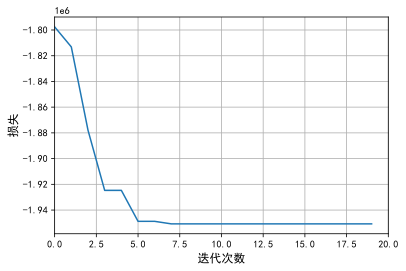

In [50]:
# 损失函数
def asset_cost(x):
    data=sh
    match_days=int(x[6])
    trade_days=int(x[7])
    account=Cointe.main_(data,match_days,trade_days,x[0],x[1],x[2],x[3],x[4],x[5])
    account=Cointe.merge_(data,account)
    return -account.iloc[-1,5]

# 定义问题
problem = structure()
problem.costfunc = asset_cost
problem.nvar = 8
problem.varmin = [ 0,0,1,1,2,2,30,30]
problem.varmax = [ 2,2,4,4,5,5,120,120]


# GA参数
params = structure()
params.maxit = 50
params.npop = 12
params.beta = 1
params.pc = 2
params.gamma = 0.05
params.mu = 0.01
params.sigma = 0.2

# 运行
out = run(problem, params)

# 结果
plt.plot(out.bestcost)
print(out.bestsol)
plt.xlim(0, params.maxit)
plt.xlabel('迭代次数',fontsize='12')
plt.ylabel('损失',fontsize='12')
#plt.title('遗传算法阈值寻优 ')
plt.grid(True)
plt.savefig('GA寻优结果.svg')
plt.show()

##### 使用遗传算法寻优后的参数显示训练集上的结果

In [51]:
## 给出结果函数
def give_results(sh,x,file_name):
    match_days,trade_days=int(x[6]),int(x[7])
    account=Cointe.main_(sh,match_days,trade_days,x[0],x[1],x[2],x[3],x[4],x[5])
    account=Cointe.merge_(sh,account)
    Cointe.plot_account(account,file_name)
    return account

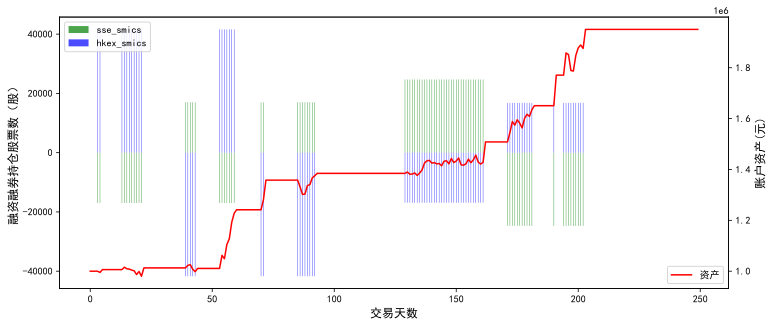

In [55]:
x=0.32830129,  0.37965625,  2.39448436,  3.18734567,  2.91786713,   4.28297531, 71.39740922, 94.16808144

# 得出训练集结果
account_train=give_results(sh,x,'实证19')
#account_train.to_excel('实证19.xlsx')

#### 4.3.3在检验集上进行测试

In [5]:
# 读取中芯国际A股和H股实证期之后的测试数据集，进行验证
test=pd.read_csv('test.csv')
test_sh=sh[['sse_smics','hkex_smics']]
test_sh['date']=[str(x)[:10] for x in test_sh.index]
test_all=pd.concat([test_sh.iloc[-int(x[6]):,:],test],axis=0).set_index(['date'])

# 得出测试集结果
account_test=give_results(test_all,x,'test19')

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [4]:
sh

,hkex.hsi,sse.ci,hkex_smics,sse_smics
date,,,,
2020-07-16,24970.68945,3210.099121,28.750000,82.919998
2020-07-17,25089.16992,3214.128906,29.000000,77.059998
2020-07-20,25057.99023,3314.148926,28.200001,79.169998
2020-07-21,25635.66016,3320.895020,29.350000,78.629997
2020-07-22,25057.93945,3333.164063,27.000000,79.570000
...,...,...,...,...
2021-10-13,24962.58984,3561.760010,21.549999,54.389999
2021-10-14,24962.58984,3558.280029,21.549999,54.169998
2021-10-15,25330.96094,3572.370117,21.600000,54.980000
